코드를 분석해 보면 ResNet50 모델을 생성하기 위해서 반복적으로 활용하는 conv_block과 identity_block이 있을 것입니다. 
이런 블록 구조를 잘 활용하여, 50개나 되는 복잡한 레이어 구조를 간결하게 표현하고 있는 것을 확인하실 수 있습니다

In [ ]:
# 추가로 import해야 할 패키지들을 먼저 가져옵니다. 
import tensorflow as tf 
from tensorflow.keras import backend, regularizers, initializers, models
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.utils import plot_model


# block 안에 반복적으로 활용되는 L2 regularizer를 선언해 줍니다.
def _gen_l2_regularizer(use_l2_regularizer=True, l2_weight_decay=1e-4):
  return regularizers.l2(l2_weight_decay) if use_l2_regularizer else None

In [ ]:
# CIFAR100 데이터셋을 가져옵시다. 
cifar10 = keras.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

print("x_train:", len(x_train), "x_test:", len(x_test))

x_train: 50000 x_test: 10000


In [ ]:
def conv_blocks(input_tensor,
                kernel_size,
                filters,
                stage,
                block,
                strides=(2,2),
                use_l2_regularizer=True,
                batch_norm_decay=0.9,
                batch_norm_epsilon=1e-5):
  
  filters1,filters2,filters3=filters

  if backend.image_data_format() == 'channels_last':
    bn_axis=3
  else:
    bn_axis=1

  conv_base_name = 'conv' + str(stage) + block + '_branch'
  bn_base_name = 'bn' + str(stage) + block + '_branch'

  x = layers.Conv2D(filters1,(1,1), use_bias=False,
                    kernel_initializer='he_normal',
                    kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
                    name=conv_base_name+'2a')(input_tensor)

  x = layers.BatchNormalization(axis=bn_axis,
                                momentum = batch_norm_decay,
                                epsilon = batch_norm_epsilon,
                                name = bn_base_name + '2a')(x)

  x = layers.Activation('relu')(x)

  x = layers.Conv2D(filters2, kernel_size, strides= strides,padding='same',use_bias=False,
                    kernel_initializer='he_normal',
                    kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
                    name=conv_base_name + '2b')(x)

  x = layers.BatchNormalization(axis=bn_axis,
                                momentum = batch_norm_decay,
                                epsilon = batch_norm_epsilon,
                                name = bn_base_name + '2b')(x)

  x = layers.Activation('relu')(x)

  x = layers.Conv2D(filters3,(1,1), use_bias=False,
                    kernel_initializer='he_normal',
                    kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
                    name=conv_base_name+'2c')(x)

  x = layers.BatchNormalization(axis=bn_axis,
                                momentum = batch_norm_decay,
                                epsilon = batch_norm_epsilon,
                                name = bn_base_name + '2c')(x)


  shortcut = layers.Conv2D(filters3,(1,1),strides=strides, use_bias=False,
                           kernel_initializer='he_normal',
                           kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
                           name=conv_base_name+'1')(input_tensor)

  shortcut = layers.BatchNormalization(axis=bn_axis,
                                momentum = batch_norm_decay,
                                epsilon = batch_norm_epsilon,
                                name = bn_base_name + '1')(shortcut)

  x = layers.add([x, shortcut])
  x = layers.Activation('relu')(x)

  return x

In [ ]:
def identity_block(input_tensor,
                    kernel_size,
                    filters,
                    stage,
                    block,
                    use_l2_regularizer=True,
                    batch_norm_decay=0.9,
                    batch_norm_epsilon=1e-5):
  
  filters1,filters2,filters3 = filters

  if backend.image_data_format()=='channels_last':
    bn_axis=3
  else:
    bn_axis=1

  id_base_name = 'identity' + str(stage) + block + '_branch'
  bn_base_name = 'identity_bn' + str(stage) + block + '_branch'

  x = layers.Conv2D(filters1,(1,1),use_bias=False,kernel_initializer='he_normal',
                    kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
                    name=id_base_name+'2a')(input_tensor)

  x = layers.BatchNormalization(axis=bn_axis,
                                momentum=batch_norm_decay,
                                epsilon=batch_norm_epsilon,
                                name=bn_base_name+'2a')(x)

  x = layers.Activation('relu')(x)

  x = layers.Conv2D(filters2,kernel_size,padding='same',use_bias=False,
                    kernel_initializer='he_normal',
                    kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
                    name = id_base_name+'2b')(x)

  x = layers.BatchNormalization(axis=bn_axis,
                         momentum = batch_norm_decay,
                         epsilon =batch_norm_epsilon,
                         name= bn_base_name+'2b')(x)

  x = layers.Activation('relu')(x)

  x = layers.Conv2D(filters3,(1,1),use_bias=False,
                    kernel_initializer='he_normal',
                    kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
                    name = id_base_name+'2c')(x)

  x = layers.BatchNormalization(axis=bn_axis,
                                momentum=batch_norm_decay,
                                epsilon=batch_norm_epsilon,
                                name=bn_base_name+'2c')(x)

  x = layers.add([x,input_tensor])
  x = layers.Activation('relu')(x)

  return x

In [ ]:
def resnet50_1(num_classes,
             batch_size=None,
             use_l2_regularizer=True,
             rescale_inputs=False,
             batch_norm_decay=0.9,
             batch_norm_epsilon=1e-5):

  input_shape = (32, 32, 3)  # CIFAR100을 위한 input_shape 조정입니다. 
  img_input = layers.Input(shape=input_shape, batch_size=batch_size)

  if backend.image_data_format() == 'channels_first':
    x = layers.Permute((3, 1, 2))(img_input)
    bn_axis = 1
  else:  # channels_last
    bn_axis = 3

  block_config = dict(
      use_l2_regularizer=use_l2_regularizer,
      batch_norm_decay=batch_norm_decay,
      batch_norm_epsilon=batch_norm_epsilon)
  x = layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(img_input)
  x = layers.Conv2D(
      64, (7, 7),
      strides=(2, 2),
      padding='valid',
      use_bias=False,
      kernel_initializer='he_normal',
      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      name='conv1')(
          x)
  x = layers.BatchNormalization(
      axis=bn_axis,
      momentum=batch_norm_decay,
      epsilon=batch_norm_epsilon,
      name='bn_conv1')(
          x)
  x = layers.Activation('relu')(x)
  x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

  x = conv_blocks(
      x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1), **block_config)
  x = identity_block(x, 3, [64, 64, 256], stage=2, block='b', **block_config)
  x = identity_block(x, 3, [64, 64, 256], stage=2, block='c', **block_config)

  x = conv_blocks(x, 3, [128, 128, 512], stage=3, block='a', **block_config)
  x = identity_block(x, 3, [128, 128, 512], stage=3, block='b', **block_config)
  x = identity_block(x, 3, [128, 128, 512], stage=3, block='c', **block_config)
  x = identity_block(x, 3, [128, 128, 512], stage=3, block='d', **block_config)

  x = conv_blocks(x, 3, [256, 256, 1024], stage=4, block='a', **block_config)
  x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b', **block_config)
  x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c', **block_config)
  x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d', **block_config)
  x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e', **block_config)
  x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f', **block_config)

  x = conv_blocks(x, 3, [512, 512, 2048], stage=5, block='a', **block_config)
  x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b', **block_config)
  x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c', **block_config)

  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(
      num_classes,
      kernel_initializer=initializers.RandomNormal(stddev=0.01),
      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      bias_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      name='fc1000')(
          x)

  # A softmax that is followed by the model loss must be done cannot be done
  # in float16 due to numeric issues. So we pass dtype=float32.
  x = layers.Activation('softmax', dtype='float32')(x)

  # Create model.
  return models.Model(img_input, x, name='resnet50')

In [ ]:
resnet_50 = resnet50_1(num_classes=10)
resnet_50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_2[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 16, 16, 64)   9408        ['conv1_pad[0][0]']              
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1[0][0]']                  
                                                                                           

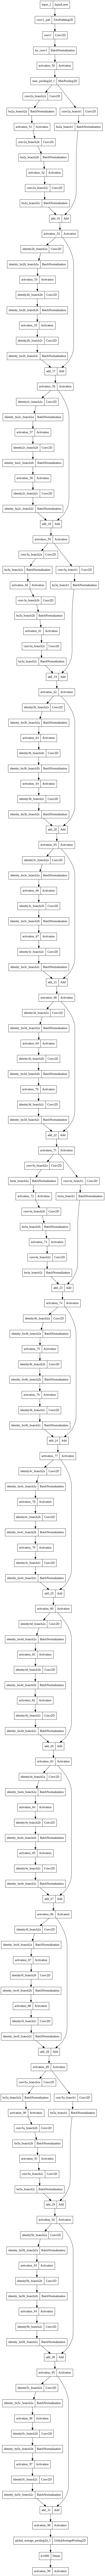

In [ ]:
plot_model(resnet_50)

In [ ]:
resnet_50.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_resnet50 = resnet_50.fit(x_train, y_train, epochs=100)

In [ ]:
def plain_conv_blocks(input_tensor,
                      kernel_size,
                      filters,
                      stage,
                      block,
                      strides=(2,2),
                      use_l2_regularizer=True,
                      batch_norm_decay=0.9,
                      batch_norm_epsilon=1e-5):
  
  filters1,filters2,filters3=filters

  if backend.image_data_format() == 'channels_last':
    bn_axis=3
  else:
    bn_axis=1

  conv_base_name = 'conv' + str(stage) + block + '_branch'
  bn_base_name = 'bn' + str(stage) + block + '_branch'

  x = layers.Conv2D(filters1,(1,1), use_bias=False,
                    kernel_initializer='he_normal',
                    kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
                    name=conv_base_name+'2a')(input_tensor)

  x = layers.BatchNormalization(axis=bn_axis,
                                momentum = batch_norm_decay,
                                epsilon = batch_norm_epsilon,
                                name = bn_base_name + '2a')(x)

  x = layers.Activation('relu')(x)

  x = layers.Conv2D(filters2, kernel_size, strides= strides,padding='same',use_bias=False,
                    kernel_initializer='he_normal',
                    kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
                    name=conv_base_name + '2b')(x)

  x = layers.BatchNormalization(axis=bn_axis,
                                momentum = batch_norm_decay,
                                epsilon = batch_norm_epsilon,
                                name = bn_base_name + '2b')(x)

  x = layers.Activation('relu')(x)

  x = layers.Conv2D(filters3,(1,1), use_bias=False,
                    kernel_initializer='he_normal',
                    kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
                    name=conv_base_name+'2c')(x)

  x = layers.BatchNormalization(axis=bn_axis,
                                momentum = batch_norm_decay,
                                epsilon = batch_norm_epsilon,
                                name = bn_base_name + '2c')(x)

  x = layers.Activation('relu')(x)

  return x

In [ ]:
def plain_identity_block(input_tensor,
                         kernel_size,
                         filters,
                         stage,
                         block,
                         use_l2_regularizer=True,
                         batch_norm_decay=0.9,
                         batch_norm_epsilon=1e-5):
  
  filters1,filters2,filters3 = filters

  if backend.image_data_format()=='channels_last':
    bn_axis=3
  else:
    bn_axis=1

  id_base_name = 'identity' + str(stage) + block + '_branch'
  bn_base_name = 'identity_bn' + str(stage) + block + '_branch'

  x = layers.Conv2D(filters1,(1,1),use_bias=False,kernel_initializer='he_normal',
                    kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
                    name=id_base_name+'2a')(input_tensor)

  x = layers.BatchNormalization(axis=bn_axis,
                                momentum=batch_norm_decay,
                                epsilon=batch_norm_epsilon,
                                name=bn_base_name+'2a')(x)

  x = layers.Activation('relu')(x)

  x = layers.Conv2D(filters2,kernel_size,padding='same',use_bias=False,
                    kernel_initializer='he_normal',
                    kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
                    name = id_base_name+'2b')(x)

  x = layers.BatchNormalization(axis=bn_axis,
                         momentum = batch_norm_decay,
                         epsilon =batch_norm_epsilon,
                         name= bn_base_name+'2b')(x)

  x = layers.Activation('relu')(x)

  x = layers.Conv2D(filters3,(1,1),use_bias=False,
                    kernel_initializer='he_normal',
                    kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
                    name = id_base_name+'2c')(x)

  x = layers.BatchNormalization(axis=bn_axis,
                                momentum=batch_norm_decay,
                                epsilon=batch_norm_epsilon,
                                name=bn_base_name+'2c')(x)

  x = layers.Activation('relu')(x)

  return x

In [ ]:
def plain50(num_classes,
            batch_size=None,
            use_l2_regularizer=True,
            rescale_inputs=False,
            batch_norm_decay=0.9,
            batch_norm_epsilon=1e-5):

  input_shape = (32, 32, 3)  # CIFAR100을 위한 input_shape 조정입니다. 
  img_input = layers.Input(shape=input_shape, batch_size=batch_size)

  if backend.image_data_format() == 'channels_first':
    x = layers.Permute((3, 1, 2))(img_input)
    bn_axis = 1
  else:  # channels_last
    bn_axis = 3

  block_config = dict(
      use_l2_regularizer=use_l2_regularizer,
      batch_norm_decay=batch_norm_decay,
      batch_norm_epsilon=batch_norm_epsilon)
  x = layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(img_input)
  x = layers.Conv2D(
      64, (7, 7),
      strides=(2, 2),
      padding='valid',
      use_bias=False,
      kernel_initializer='he_normal',
      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      name='conv1')(
          x)
  x = layers.BatchNormalization(
      axis=bn_axis,
      momentum=batch_norm_decay,
      epsilon=batch_norm_epsilon,
      name='bn_conv1')(
          x)
  x = layers.Activation('relu')(x)
  x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

  x = plain_conv_blocks(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1), **block_config)
  x = plain_identity_block(x, 3, [64, 64, 256], stage=2, block='b', **block_config)
  x = plain_identity_block(x, 3, [64, 64, 256], stage=2, block='c', **block_config)

  x = plain_conv_blocks(x, 3, [128, 128, 512], stage=3, block='a', **block_config)
  x = plain_identity_block(x, 3, [128, 128, 512], stage=3, block='b', **block_config)
  x = plain_identity_block(x, 3, [128, 128, 512], stage=3, block='c', **block_config)
  x = plain_identity_block(x, 3, [128, 128, 512], stage=3, block='d', **block_config)

  x = plain_conv_blocks(x, 3, [256, 256, 1024], stage=4, block='a', **block_config)
  x = plain_identity_block(x, 3, [256, 256, 1024], stage=4, block='b', **block_config)
  x = plain_identity_block(x, 3, [256, 256, 1024], stage=4, block='c', **block_config)
  x = plain_identity_block(x, 3, [256, 256, 1024], stage=4, block='d', **block_config)
  x = plain_identity_block(x, 3, [256, 256, 1024], stage=4, block='e', **block_config)
  x = plain_identity_block(x, 3, [256, 256, 1024], stage=4, block='f', **block_config)

  x = plain_conv_blocks(x, 3, [512, 512, 2048], stage=5, block='a', **block_config)
  x = plain_identity_block(x, 3, [512, 512, 2048], stage=5, block='b', **block_config)
  x = plain_identity_block(x, 3, [512, 512, 2048], stage=5, block='c', **block_config)

  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(
      num_classes,
      kernel_initializer=initializers.RandomNormal(stddev=0.01),
      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      bias_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      name='fc1000')(
          x)

  # A softmax that is followed by the model loss must be done cannot be done
  # in float16 due to numeric issues. So we pass dtype=float32.
  x = layers.Activation('softmax', dtype='float32')(x)

  # Create model.
  return models.Model(img_input, x, name='resnet50')

In [ ]:
plain_50 = plain50(num_classes=10)
plain_50.summary()

Model: "resnet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 3)         0         
                                                                 
 conv1 (Conv2D)              (None, 16, 16, 64)        9408      
                                                                 
 bn_conv1 (BatchNormalizatio  (None, 16, 16, 64)       256       
 n)                                                              
                                                                 
 activation_100 (Activation)  (None, 16, 16, 64)       0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                      

In [ ]:
plot_model(plain_50)

In [ ]:
plain_50.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_plain50 = plain_50.fit(x_train, y_train, epochs=100)

Epoch 1/100
1563/1563 [==============================] - 65s 39ms/step - loss: 5.5238 - accuracy: 0.1894
Epoch 2/100
1563/1563 [==============================] - 60s 38ms/step - loss: 4.0931 - accuracy: 0.2122
Epoch 3/100
1563/1563 [==============================] - 60s 38ms/step - loss: 3.2873 - accuracy: 0.2446
Epoch 4/100
1563/1563 [==============================] - 60s 38ms/step - loss: 3.1389 - accuracy: 0.1878
Epoch 5/100
1563/1563 [==============================] - 60s 38ms/step - loss: 2.9133 - accuracy: 0.1755
Epoch 6/100
1563/1563 [==============================] - 60s 38ms/step - loss: 2.8421 - accuracy: 0.1603
Epoch 7/100
1563/1563 [==============================] - 60s 39ms/step - loss: 3.1012 - accuracy: 0.1400
Epoch 8/100
1563/1563 [==============================] - 60s 38ms/step - loss: 2.9227 - accuracy: 0.1608
Epoch 9/100
1563/1563 [==============================] - 60s 38ms/step - loss: 2.9882 - accuracy: 0.1340
Epoch 10/100
1563/1563 [==============================]

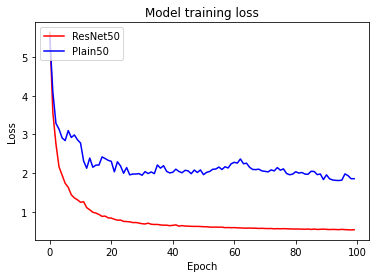

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_resnet50.history['loss'], 'r')
plt.plot(history_plain50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet50','Plain50'], loc='upper left')
plt.show()

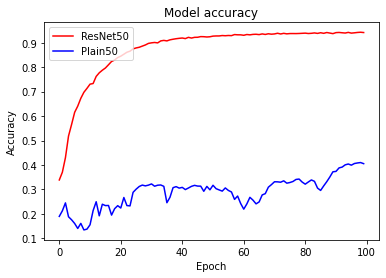

In [ ]:
plt.plot(history_resnet50.history['accuracy'], 'r')
plt.plot(history_plain50.history['accuracy'], 'b')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet50', 'Plain50'], loc='upper left')
plt.show()